#Downloading the Resource files from GitHub

In [1]:
!git clone https://github.com/venmurasu-programming-team/Aug2021-contest.git

Cloning into 'Aug2021-contest'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 87 (delta 24), reused 59 (delta 15), pack-reused 0
Unpacking objects: 100% (87/87), done.


#Importing the Modules

In [16]:
import tensorflow as tf
import numpy as np
import keras
import pandas as pd
import re


In [138]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Flatten, RNN, Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras import *
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

#Fine Tuning the text

In [6]:
removeAll = lambda a,b : list(filter((b).__ne__, a))

def FineTune(path):
  arr2 = []
  arr3 = []
  with open(path) as f:
    cont = f.read().lower().strip()
    cont = re.split("[\n\.]",cont)
    for i in cont:
      if re.search("parva", i):
        continue
      else:
        arr3.append(i)
    cont = ".".join(arr3)
    #cont = re.sub("\{\w+\}", "", cont)
    cont = re.sub("(\(?section\s*[ivxlc]+\)?)|(p\.\s+\d+)|([\(\)\"\'\{\}\d+])|(if)|(footnotes)|(\")|(\')", "", cont)
    cont.replace("i\.e\.,","")
    cont.replace("-"," ")
    cont.replace("\n"," ")
    arr = re.split("[.;,\n]", cont)
    for i in arr:
      s = i.split(" ")
      s = removeAll(removeAll(s, "ie"), "")
      arr2.append(s)
      #print(s)

  return removeAll(removeAll(removeAll(arr2, []), ["e"]),["-"])

In [7]:
def FineTuneBoth(num):
  BASE_PATH = "/content/Aug2021-contest/resources/Mahabharatha-Adiparva-Section{}-{}.txt"
  arr = FineTune(BASE_PATH.format(num,"en"))
  arr2 = FineTune(BASE_PATH.format(num,"ta"))
  rem = abs(len(arr) - len(arr2))
  toBeAdded = arr2[-rem:]
  for i in range(-rem,0):
    arr2.insert(i, toBeAdded[i])
  return (arr, arr2)

In [8]:
#arrBoth = FineTuneBoth(28)
#print(len(arrBoth[0]), len(arrBoth[1]))

#Generating the data from raw data

In [9]:
file_nums = list(range(22, 32))
formats = ["en", "ta"]

In [10]:
eng_arr = []
tam_arr = []

for i in file_nums:
  temp = FineTuneBoth(i)
  if(len(temp[0]) == len(temp[1])):
    print("file :",i, len(temp[0]), len(temp[1]))
  else:
    continue
  eng_arr.extend(temp[0])
  tam_arr.extend(temp[1])

eng_arr = [" ".join(i) for i in eng_arr]
tam_arr = [" ".join(i) for i in tam_arr]

print("english length :",len(eng_arr))
print("tamil length :",len(tam_arr))

file : 22 48 48
file : 23 146 146
file : 24 70 70
file : 25 86 86
file : 26 28 28
file : 27 76 76
file : 28 95 95
file : 29 173 173
file : 30 188 188
file : 31 140 140
english length : 1050
tamil length : 1050


In [13]:
csv_arr = [("English", "Tamil")]
for i in range(len(eng_arr)):
  csv_arr.append((eng_arr[i], tam_arr[i]))

np.savetxt("final_data.csv", csv_arr, delimiter =", ", fmt ='% s')

#Tokenizing

In [57]:
eng_tokenizer = Tokenizer(num_words=1050, oov_token='<OOV>')
eng_tokenizer.fit_on_texts(eng_arr)
eng_seq = eng_tokenizer.texts_to_sequences(eng_arr)
total_eng_words = len(eng_tokenizer.word_index)
#print(*eng_seq,sep="\n")
eng_seq = tf.keras.preprocessing.sequence.pad_sequences(eng_seq, padding='post')
#print(eng_seq[8])

In [238]:
eng_words = {v: k for k, v in eng_tokenizer.word_index.items()}
eng_words[0] = "<OOV>"


In [120]:
tam_tokenizer = Tokenizer(num_words=1050, oov_token='<OOV>')
tam_tokenizer.fit_on_texts(tam_arr)
tam_seq = tam_tokenizer.texts_to_sequences(tam_arr)
total_tam_words = len(tam_tokenizer.word_index)
tam_seq = tf.keras.preprocessing.sequence.pad_sequences(tam_seq, padding='post')
print(tam_seq.shape)

(1050, 27)


In [286]:
tam_train, tam_test, eng_train, eng_test = train_test_split(tam_seq, eng_seq, test_size=0.33, random_state=42)

In [287]:
eng_train[0]

array([826,  19,   2, 349,   3,   2, 276,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

#Building the Model

In [296]:
model = Sequential()
dim = tam_seq.shape[1]
model.add(Input(shape=(dim,)))
model.add(Input(shape=(dim,)))
model.add(Dense(dim*2, activation='relu'))
model.add(Dense(eng_seq.shape[1], activation=tf.keras.layers.LeakyReLU(alpha=-1)))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [297]:
model.summary()

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        multiple                  0         
_________________________________________________________________
dense_105 (Dense)            (None, 54)                1512      
_________________________________________________________________
dense_106 (Dense)            (None, 41)                2255      
Total params: 3,767
Trainable params: 3,767
Non-trainable params: 0
_________________________________________________________________


In [298]:
earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=100, verbose=0, mode='auto')
history = model.fit((tam_seq,tam_seq), eng_seq, epochs=300, validation_data=(tam_seq, eng_seq), callbacks=[earlystop])

Epoch 1/300
33/33 [==============================] - 1s 8ms/step - loss: -305.9040 - accuracy: 0.0381 - val_loss: -310.4026 - val_accuracy: 0.0562
Epoch 2/300
33/33 [==============================] - 0s 4ms/step - loss: -310.0953 - accuracy: 0.0762 - val_loss: -312.9117 - val_accuracy: 0.0971
Epoch 3/300
33/33 [==============================] - 0s 4ms/step - loss: -313.8033 - accuracy: 0.1114 - val_loss: -315.6004 - val_accuracy: 0.1371
Epoch 4/300
33/33 [==============================] - 0s 4ms/step - loss: -314.1931 - accuracy: 0.1495 - val_loss: -313.3267 - val_accuracy: 0.1571
Epoch 5/300
33/33 [==============================] - 0s 4ms/step - loss: -315.1352 - accuracy: 0.1676 - val_loss: -316.4770 - val_accuracy: 0.1724
Epoch 6/300
33/33 [==============================] - 0s 4ms/step - loss: -316.6855 - accuracy: 0.1752 - val_loss: -318.4083 - val_accuracy: 0.1876
Epoch 7/300
33/33 [==============================] - 0s 3ms/step - loss: -318.5692 - accuracy: 0.1876 - val_loss: -320

In [299]:
model.save("model.h5")

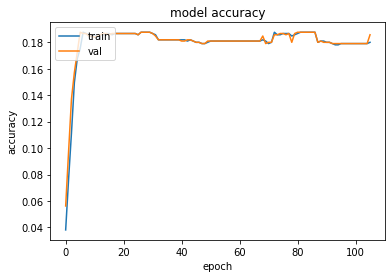

In [300]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#Saving the generated data

In [301]:
removeAll = lambda a,b : list(filter((b).__ne__, a))
result = list(model.predict(tam_seq))
result = [[round(x) for x in i] for i in result]
print(*result, sep="\n")

[17, 5, 9, 2, 5, 8, 12, 5, 8, 11, 9, 2, 8, 6, 7, 7, 0, 4, 5, 1, 5, 4, 4, 7, 5, 7, 0, 4, 6, 4, 2, 4, 6, 4, 4, 1, 5, 1, 0, 4, 5]
[721, 331, 304, 279, 17, 175, 313, 101, 253, 579, 541, 136, 106, 32, 143, 387, 169, 15, 247, 193, 94, 119, 88, 76, 46, 255, 42, 13, 43, 84, 203, 35, 233, 168, 52, 251, 132, 237, 9, 148, 25]
[1344, 313, 641, 332, 239, 128, 579, 56, 120, 966, 1322, 195, 961, 353, 89, 511, 138, 72, 129, 303, 52, 563, 531, 221, 92, 571, 42, 641, 325, 126, 239, 413, 146, 115, 388, 144, 150, 76, 275, 103, 58]
[719, 366, 283, 271, 43, 127, 295, 88, 277, 575, 530, 131, 108, 11, 147, 381, 187, 32, 263, 187, 98, 111, 93, 57, 43, 256, 37, 12, 50, 74, 192, 35, 243, 171, 57, 240, 134, 235, 20, 143, 9]
[919, 335, 567, 84, 241, 329, 694, 172, 159, 561, 569, 141, 255, 142, 209, 463, 100, 141, 229, 146, 180, 225, 97, 290, 97, 266, 130, 208, 223, 366, 15, 208, 314, 184, 274, 208, 327, 84, 45, 26, 221]
[690, 176, 494, 161, 511, 443, 498, 423, 271, 430, 488, 138, 344, 207, 226, 240, 55, 176, 81, 1

In [302]:
strArr = lambda x : list(map(str, x))

compare = [("English Original", "English Predicted")]
for i in range(len(eng_seq)):
  compare.append([" ".join(strArr(removeAll(eng_seq[i],0))), " ".join(strArr(result[i]))])
print(compare)
np.savetxt("translations.csv", compare, delimiter =", ", fmt ='% s')

[('English Original', 'English Predicted'), ['48 30 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0', '17 5 9 2 5 8 12 5 8 11 9 2 8 6 7 7 0 4 5 1 5 4 4 7 5 7 0 4 6 4 2 4 6 4 4 1 5 1 0 4 5'], ['2 170 150 693 307 20 2 694 6 31 424 134 42 247 425 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0', '721 331 304 279 17 175 313 101 253 579 541 136 106 32 143 387 169 15 247 193 94 119 88 76 46 255 42 13 43 84 203 35 233 168 52 251 132 237 9 148 25'], ['27 119 695 7 696 59 106 119 205 697 59 426 4 171 44 14 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0', '1344 313 641 332 239 128 579 56 120 966 1322 195 961 353 89 511 138 72 129 303 52 563 531 221 92 571 42 641 325 126 239 413 146 115 388 144 150 76 275 103 58'], ['32 2 49 698 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0', '719 366 283 271 43 127 295 88 277 575 530 131 108 11 147 381 187 32 263 187 98 111 93 57 43 256 37 12 50 74 192 35 243 171 57 240 134 235 20 143 9'], ['119 45

#BRLU Score

Sorry we could able to complete till the model building only ...